Dataset from: https://www.kaggle.com/datasets/techsash/waste-classification-data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing the libraries and intializing the path variables

In [2]:
import numpy as np 
import pandas as pd 
import os
import shutil
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from PIL import Image

In [7]:
data_path = '/content/drive/MyDrive/waste_segregation/v001/DATASET'
folder_path = '/content/drive/MyDrive/waste_segregation/v001/'
save_model_path = '/content/drive/MyDrive/waste_segregation/v001/saved_models/'
visualisation_path = '/content/drive/MyDrive/waste_segregation/v001/visualisations/'

In [4]:
if not os.path.exists(save_model_path):  # Creating the directory if it does not exist
    os.makedirs(save_model_path)

if not os.path.exists(visualisation_path):  # Creating the directory if it does not exist
    os.makedirs(visualisation_path)

In [5]:
# Constants

IMAGE_DIMS = (224, 224)
IMAGE_SIZE = (224, 224, 3)
BATCH_SIZE = 32
MODEL_EPOCHS = 40

# Unzipping Images

Dataset on Kaggle: https://www.kaggle.com/datasets/techsash/waste-classification-data

In [8]:
if not os.path.exists(data_path):  # unzipping only if it is not already unzipped
  shutil.unpack_archive(folder_path + "archive.zip", folder_path)

In [9]:
glob(data_path + '*/')

['/content/drive/MyDrive/waste_segregation/v001/DATASET/']

In [10]:
# code for getting all files in a directory
# inspired from https://theprogrammingexpert.com/count-number-of-files-in-directory-python/

def count_number_of_files(path):
    print("Main Directory:", path)
    print("Files in Main Directory:", len(os.listdir(path)))
    print("\nSub-Directories:")
    for root, dirs, files in os.walk(path):
        for name in dirs:
            print(os.path.join(root,name), ":", len(os.listdir(os.path.join(root,name))))
            # print()
            # print(files)

count_number_of_files(data_path)

Main Directory: /content/drive/MyDrive/waste_segregation/v001/DATASET
Files in Main Directory: 2

Sub-Directories:
/content/drive/MyDrive/waste_segregation/v001/DATASET/TEST : 2
/content/drive/MyDrive/waste_segregation/v001/DATASET/TRAIN : 2
/content/drive/MyDrive/waste_segregation/v001/DATASET/TEST/O : 1401
/content/drive/MyDrive/waste_segregation/v001/DATASET/TEST/R : 1112
/content/drive/MyDrive/waste_segregation/v001/DATASET/TRAIN/O : 12565
/content/drive/MyDrive/waste_segregation/v001/DATASET/TRAIN/R : 9999


In [11]:
dataset_classes = {'R - Train' : 9999,
                   'R - Test' : 1112,
                   'O - Train' : 12565,
                   'O - Test' : 1401}
df_dataset_classes = pd.DataFrame(dataset_classes.items(), columns=['Category', 'No_of_Images'])
df_dataset_classes = df_dataset_classes.sort_values(by='No_of_Images', ascending=False)
df_dataset_classes.reset_index(drop=True, inplace=True)
df_dataset_classes.head()

,Category,No_of_Images
0,O - Train,12565
1,R - Train,9999
2,O - Test,1401
3,R - Test,1112


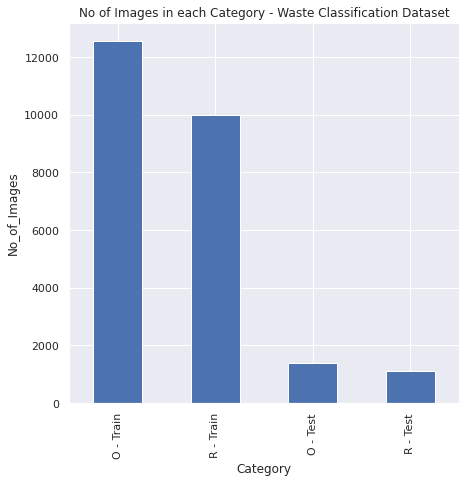

In [12]:
df_dataset_classes.plot.bar(x = 'Category',
                            y = 'No_of_Images',
                            xlabel = 'Category', 
                            ylabel = 'No_of_Images', 
                            legend = False,
                            figsize=(7,7))
plt.title('No of Images in each Category - Waste Classification Dataset')

plt.savefig(os.path.join(visualisation_path, 'class_distribution.png'), 
            dpi=300, bbox_inches='tight')

# Augmentation using ImageDataGenerator

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [33]:
# construct the training image generator for data augmentation

train_datagen_aug = ImageDataGenerator(rotation_range = 20,
                                       zoom_range = 0.15,
                                       width_shift_range = 0.2,
                                       height_shift_range = 0.2,
                                       shear_range = 0.15,
                                       horizontal_flip = True,
                                       fill_mode = "nearest",
                                       validation_split=0.15)

test_datagen_aug = ImageDataGenerator(rescale = 1./255)

# Creating training, validation and test datasets

In [34]:
training_set = train_datagen_aug.flow_from_directory(data_path+'/TRAIN',
                                                 target_size = IMAGE_DIMS,
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 subset='training')

validation_set = train_datagen_aug.flow_from_directory(data_path+'/TRAIN',
                                                  target_size = IMAGE_DIMS,
                                                  batch_size = BATCH_SIZE,
                                                  class_mode = 'categorical',
                                                  subset='validation')

test_set = test_datagen_aug.flow_from_directory(data_path+'/TEST',
                                                target_size = IMAGE_DIMS,
                                                batch_size=BATCH_SIZE,
                                                class_mode = 'categorical',
                                                shuffle=False)

Found 19181 images belonging to 2 classes.
Found 3383 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


# Creating Model Checkpoints

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_checkpoint_callback = ModelCheckpoint(filepath=os.path.join(save_model_path, 
                                                   "modelv001_RN01_{epoch:02d}.h5"), 
                                            save_best_only=True,
                                            save_weights_only=False,
                                            monitor='val_loss',
                                            mode='min')

In [36]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_reduction_callback = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                                     patience = 2, 
                                                     verbose = 1, 
                                                     factor = 0.5, 
                                                     min_lr = 1e-6)

In [37]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=5)

# ResNet Model

In [38]:
# import the necessary packages
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras import optimizers, Model, layers
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50

In [39]:
# load the ResNet network
base_model = ResNet50(weights = "imagenet", 
                      include_top = False,
                      input_tensor = Input(IMAGE_SIZE))

In [40]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [41]:
# construct the head of the model that will be placed on top of the
# the base model

last_layer = base_model.layers[-1]
print('last layer output shape: ', last_layer.output_shape)

head_model = last_layer.output
head_model = layers.Flatten()(head_model)
head_model = layers.Dense(2, activation = "softmax")(head_model) # 2 classes, namely Organic (O) and Recyclable (R)

last layer output shape:  (None, 7, 7, 2048)


In [42]:
# place the head model on top of the base model
final_model = Model(inputs = base_model.input, outputs = head_model)

In [43]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in base_model.layers:
    layer.trainable = False

In [44]:
# compile our model
print("[INFO] compiling model...")

final_model.compile(loss = "categorical_crossentropy", 
                    optimizer='adam',
                    metrics = ["accuracy"])

print("\n\n[INFO] model compilation complete!")

[INFO] compiling model...


[INFO] model compilation complete!


In [45]:
# train the head of the network
print("[INFO] model training - epochs and summary...\n\n")

final_model_history = final_model.fit(training_set,
                                      validation_data = validation_set,
                                      steps_per_epoch = len(training_set) // BATCH_SIZE,
                                      validation_steps = len(validation_set) // BATCH_SIZE,
                                      epochs = MODEL_EPOCHS,
                                      callbacks = [model_checkpoint_callback, 
                                                   early_stopping_callback, 
                                                   learning_rate_reduction_callback])

print("\n\n[INFO] model training complete!\n\n")

[INFO] model training - epochs and summary...


Epoch 1/40
18/18 [==============================] - 19s 914ms/step - loss: 3.5294 - accuracy: 0.7934 - val_loss: 1.7356 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 2/40
18/18 [==============================] - 10s 545ms/step - loss: 2.9061 - accuracy: 0.8438 - val_loss: 3.7281 - val_accuracy: 0.8646 - lr: 0.0010
Epoch 3/40
18/18 [==============================] - 10s 542ms/step - loss: 2.9376 - accuracy: 0.8507 - val_loss: 2.5604 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 4/40
18/18 [==============================] - 13s 723ms/step - loss: 2.7897 - accuracy: 0.8542 - val_loss: 3.0771 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 5/40
18/18 [==============================] - ETA: 0s - loss: 2.9676 - accuracy: 0.8594
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
18/18 [==============================] - 15s 880ms/step - loss: 2.9676 - accuracy: 0.8594 - val_loss: 2.5454 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 6/40
18

In [46]:
final_model_history_df = pd.DataFrame(final_model_history.history)
final_model_history_df

,loss,accuracy,val_loss,val_accuracy,lr
0,3.529412,0.793403,1.735583,0.875000,0.0010
1,2.906088,0.843750,3.728149,0.864583,0.0010
2,2.937632,0.850694,2.560382,0.906250,0.0010
3,2.789671,0.854167,3.077108,0.812500,0.0010
4,2.967627,0.859375,2.545385,0.812500,0.0010
5,2.314334,0.894097,2.442437,0.906250,0.0005


In [47]:
final_model_history_df.to_csv(os.path.join(save_model_path, 
                                          'v001_final_model_history.csv'),
                               index=False)

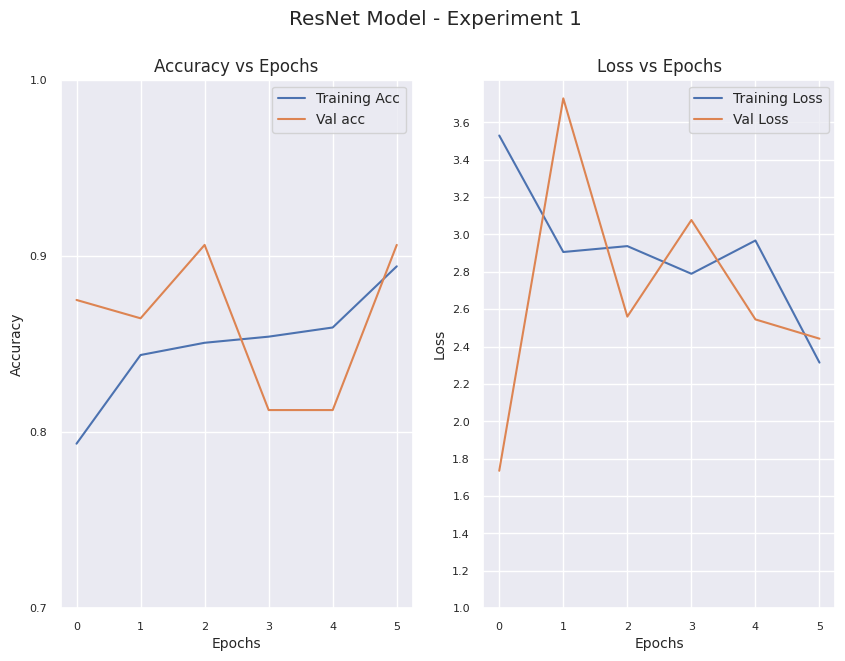

In [50]:
# Plots of Accuracy and Loss vs Epochs.

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 7), dpi=100)


fig.suptitle("ResNet Model - Experiment 1", fontdict = {'size': 10, 'weight' : 3})

ax[0].set_title('Accuracy vs Epochs')
ax[0].plot(final_model_history.history['accuracy'], label='Training Acc')
ax[0].plot(final_model_history.history['val_accuracy'], label='Val acc')
ax[0].set_xlabel('Epochs', fontsize=10)
ax[0].set_ylabel('Accuracy', fontsize=10)
ax[0].legend(fontsize=10)
ax[0].tick_params(axis='both', which='major', labelsize=8)
ax[0].xaxis.set_ticks(np.arange(0, 6, 1))
ax[0].yaxis.set_ticks(np.arange(0.7, 1.05, 0.1))

ax[1].set_title('Loss vs Epochs')
ax[1].plot(final_model_history.history['loss'], label='Training Loss')
ax[1].plot(final_model_history.history['val_loss'], label='Val Loss')
ax[1].set_xlabel('Epochs', fontsize=10)
ax[1].set_ylabel('Loss', fontsize=10)
ax[1].legend(fontsize=10)
ax[1].tick_params(axis='both', which='major', labelsize=8)
ax[1].xaxis.set_ticks(np.arange(0, 6, 1))
ax[1].yaxis.set_ticks(np.arange(1.0, 3.8, 0.2))

fig.savefig(os.path.join(visualisation_path, 
                         'v001_resnet.png'), 
            dpi=300, 
            bbox_inches='tight')

plt.show()

### Evaluating the model

In [54]:
test_labels = test_set.classes

In [61]:
target_names = ['O', 'R']

In [62]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predictions = final_model.predict(test_set, batch_size = BATCH_SIZE)
print("\n\n[INFO] evaluation complete!")

[INFO] evaluating network...


[INFO] evaluation complete!


In [63]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predictions = np.argmax(predictions, axis=-1)

In [64]:
from sklearn.metrics import classification_report, confusion_matrix

In [65]:
print(classification_report(test_labels, 
                            predictions))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01      1401
           1       0.44      1.00      0.61      1112

    accuracy                           0.44      2513
   macro avg       0.72      0.50      0.31      2513
weighted avg       0.75      0.44      0.28      2513



In [66]:
# show classification report
print(classification_report(test_labels, 
                            predictions,
                            target_names=target_names))

              precision    recall  f1-score   support

           O       1.00      0.00      0.01      1401
           R       0.44      1.00      0.61      1112

    accuracy                           0.44      2513
   macro avg       0.72      0.50      0.31      2513
weighted avg       0.75      0.44      0.28      2513



In [67]:
report = classification_report(test_labels, 
                               predictions,
                               target_names=target_names,
                               output_dict = True)

df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
O,1.000000,0.003569,0.007112,1401.000000
R,0.443381,1.000000,0.614365,1112.000000
accuracy,0.444489,0.444489,0.444489,0.444489
macro avg,0.721691,0.501784,0.310739,2513.000000
weighted avg,0.753697,0.444489,0.275821,2513.000000


In [68]:
# saving the classification report to a csv file
df_report.to_csv(os.path.join(save_model_path, 
                         'v001_resnet_classification_report.csv'),  
                  index=False)

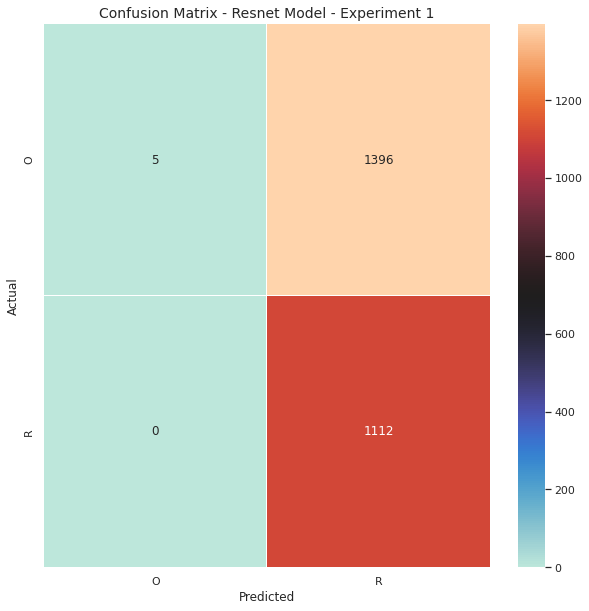

In [70]:
cm = pd.crosstab(test_labels, 
                predictions, 
                rownames=['Actual'], 
                colnames=['Predicted'])

fig, ax = plt.subplots(1, figsize=(10,10))

sns.heatmap(cm, fmt="d",
            xticklabels=target_names,
            yticklabels=target_names,
            annot=True, ax=ax,
            linewidths=0.2,linecolor="white", cmap="icefire")

ax.set_ylim(2, 0)
ax.set_xlim(0, 2)
plt.title(f'Confusion Matrix - Resnet Model - Experiment 1', fontsize=14)

plt.savefig(os.path.join(visualisation_path, 
                         'v001_confusion_matrix.png'), 
            dpi=300, bbox_inches='tight')

plt.show()
    

# Predicting on test images

Actual Category: O
Predicted Category: R


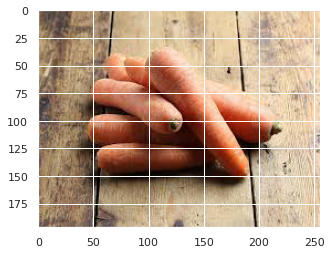

In [75]:
# Testing model performance on custom data

im1 = Image.open(data_path+"/TEST/O/O_12577.jpg")
plt.imshow(im1)
print("Actual Category: O")

# Pre-processing the image

im1 = im1.resize((224,224))
im1 = np.expand_dims(im1, axis=0)
im1 = np.array(im1)
im1 = im1/255

# Predicting using the model

pred1 = final_model.predict([im1])[0]
pred1 = np.argmax(pred1)
print("Predicted Category:", target_names[pred1])

Actual Category: R
Predicted Category: R


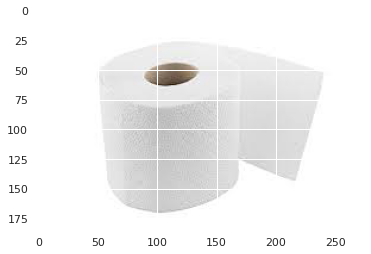

In [74]:
# Testing model performance on custom data

im2 = Image.open(data_path+"/TEST/R/R_11107.jpg")
plt.imshow(im2)
print("Actual Category: R")

# Pre-processing the image

im2 = im2.resize((224,224))
im2 = np.expand_dims(im2, axis=0)
im2 = np.array(im2)
im2 = im2/255

# Predicting using the model

pred2 = final_model.predict([im2])[0]
pred2 = np.argmax(pred2)
print("Predicted Category:", target_names[pred2])